# Reading data notes
* For reading the Data from the File
* Return a dicionery with the DataSet
* DataSet is dictionary with the following elements
* A 10000x3072 numpy array of uint8s.
* Each row of the array stores a 32x32 colour image.
* The first 1024 entries contain the red channel values,
* the next 1024 the green, and the final 1024 the blue.
* The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* Data key is b'data'
* file names key is b'filenames'
* labels key is b'labels'


**Import Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Downloading, Loading and Normalising CIFAR-10
PyTorch provides data loaders for common data sets used in vision applications, such as MNIST, CIFAR-10 and ImageNet through the `torchvision` package. Other handy tools are the `torch.utils.data.DataLoader` that we will use to load the data set for training and testing and the `torchvision.transforms`, which we will use to compose a two-step process to prepare the data for use with the CNN.

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:04, 37073711.08it/s]                               


Extracting /home/CIFAR-10 Classifier Using CNN in PyTorch/data/cifar-10-python.tar.gz to /home/CIFAR-10 Classifier Using CNN in PyTorch/data/


0it [00:00, ?it/s]

170500096it [00:04, 41713268.77it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


# Display Random Batch of 4 Training Images
Using the `trainloader` we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like.

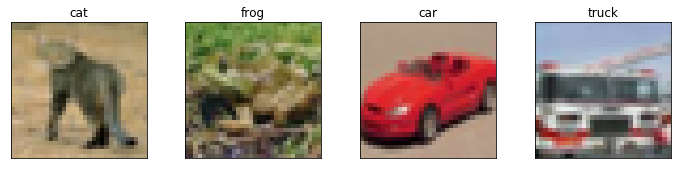

In [0]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Defining the Convolutional Neural Network
The network has the following layout,

`Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs`

where:

`Conv` is a convolutional layer, `ReLU` is the activation function, `MaxPool` is a pooling layer, `FC` is a fully connected layer and `SoftMax` is the activation function of the output layer.

## Layer Dimensions
### Input Size
The images are 3x32x32, i.e., 3 channels (red, green, blue) each of size 32x32 pixels.
### First Convolutional Layer
The first convolutional layer expects 3 input channels and will convolve 6 filters each of size 3x5x5. Since padding is set to 0 and stride is set to 1, the output size is 6x28x28, because (32−5)+1=28. This layer therefore has ((5×5×3)+1)×6=456 parameters.
### First Max-Pooling Layer
The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size from 6x28x28 to 6x14x14.
### Second Convolutional Layer
The second convolutional layers expects 6 input channels and will convolve 16 filters each of size 6x5x5. Since padding is set to 0 and stride is set to 1, the output size is 16x10x10, because 
(14−5)+1=10. This layer therefore has ((5×5×6)+1)×16=2416 parameters.
### Second Max-Pooling Layer
The second down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size from 16x10x10 to 16x5x5.
### First Fully-Connected Layer
The output from the final max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the `torch.Tensor.view` method. By specifying `-1` the method will automatically infer the number of rows required. This is done to handle the mini-batch size of data.

The fully-connected layer uses ReLU for activation and has 120 nodes, thus in total it needs 
((16×5×5)+1)×120=48120 parameters.
### Second Fully-Connected Layer
The output from the first fully-connected layer is connected to another fully connected layer with 84 nodes, using ReLU as an activation function. This layer thus needs 
(120+1)×84=10164 parameters.
### Output Layer
The last fully-connected layer uses softmax and is made up of ten nodes, one for each category in CIFAR-10. This layer requires (84+1)×10=850 parameters.
# Total Network Parameters
This convolutional neural network has a total of 456+2416+48120+10164+850=62006 parameters.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

# Defining the Loss Function and Optimizer
Since we are classifying images into more than two classes we will use cross-entropy as a loss function. To optimize the network we will employ stochastic gradient descent (SGD) with momentum to help get us over local minima and saddle points in the loss function space.

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the Network
We will now train the network using the `trainloader` data, by going over all the training data in batches of 4 images, and repeating the whole process 2 times, i.e., 2 epochs. Every 2000 batches we report on training progress by printing the current epoch and batch number along with the running loss value.

Once training is complete, we will save the model parameters to disk. This will make it possible to load the model parameters from disk the next time we run this notebook and thus not have to train the model again, saving some time.

In [0]:

import os

model_directory_path = '/home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

[1,  2000] loss: 2.235
[1,  4000] loss: 1.911
[1,  6000] loss: 1.693
[1,  8000] loss: 1.600
[1, 10000] loss: 1.523
[1, 12000] loss: 1.486
[2,  2000] loss: 1.410
[2,  4000] loss: 1.378
[2,  6000] loss: 1.364
[2,  8000] loss: 1.351
[2, 10000] loss: 1.347
[2, 12000] loss: 1.315
Finished Training.
Saved model parameters to disk.


# Testing the Network
Now that the network is trained we can evaluate how it performs on the testing data set. Let us load four random images from the testing data set and their corresponding labels.

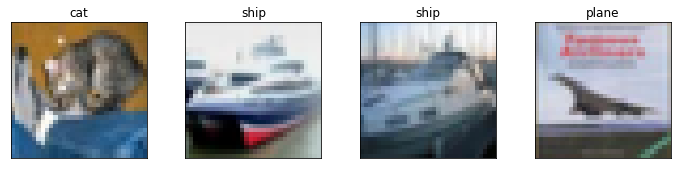

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

Next, we input the four images to the trained network to get class (label/category) predictions.

In [0]:
outputs = net(images)

The network outputs a 2D tensor (array) of size 4x10, a row for each image and a column for each category. The values are raw outputs from the linear transformation 
**y=xAT+b**
. The category predicted for each image (row) is thus the column index containing the maximum value in that row.

In [0]:
outputs

tensor([[-0.8274, -1.0562,  0.4993,  1.7715, -0.4335,  0.8290,  1.5395, -0.7941,
         -0.5256, -1.0077],
        [ 4.4627,  5.2748, -2.5606, -2.6001, -3.4147, -4.3581, -4.9039, -2.8118,
          6.0555,  5.0819],
        [ 2.7807,  4.0506, -1.6090, -1.0759, -2.6012, -2.6134, -2.6932, -2.1487,
          3.3891,  3.0645],
        [ 1.7700, -0.0201,  0.2503, -0.9165,  0.4639, -2.0456, -2.1009, -0.9756,
          2.3648,  0.2604]], grad_fn=<AddmmBackward>)

If we prefer to get a probability score, we can use the `nn.Softmax` function on the raw output as follows.

In [0]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[2.5240e-02, 2.0078e-02, 9.5111e-02, 3.3942e-01, 3.7425e-02, 1.3226e-01,
         2.6916e-01, 2.6093e-02, 3.4131e-02, 2.1075e-02],
        [9.9696e-02, 2.2458e-01, 8.8814e-05, 8.5378e-05, 3.7807e-05, 1.4718e-05,
         8.5270e-06, 6.9088e-05, 4.9023e-01, 1.8519e-01],
        [1.2853e-01, 4.5765e-01, 1.5944e-03, 2.7170e-03, 5.9114e-04, 5.8396e-04,
         5.3919e-04, 9.2938e-04, 2.3616e-01, 1.7071e-01],
        [2.5869e-01, 4.3188e-02, 5.6600e-02, 1.7623e-02, 7.0077e-02, 5.6977e-03,
         5.3910e-03, 1.6611e-02, 4.6895e-01, 5.7174e-02]],
       grad_fn=<SoftmaxBackward>)


# Predicted Category for Four Test Images

In [0]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.3394
ship - 0.4902
car - 0.4576
ship - 0.4689


The model got half of the four testing images correct. It correctly categorised the cat and plane images, but failed on the second ship and the plane images, instead categorising them as car and ship respectively. Let us now evaluate the model on the whole testing set.

# Predicting the Category for all Test Images

In [0]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 53.77%


The model performed much better than random guessing, which would give us an accuracy of 10% since there are ten categories in CIFAR-10. Let us now use the confusion matrix to compute the accuracy of the model per category.

In [0]:
print('{0:10s} - Accuarcy'.format('Category'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuarcy
plane      - 46.9
car        - 69.1
bird       - 35.5
cat        - 44.1
deer       - 38.9
dog        - 33.0
frog       - 64.8
horse      - 70.3
ship       - 68.8
truck      - 66.3


Finally, let us visualise the confusion matrix to determine common misclassifications.

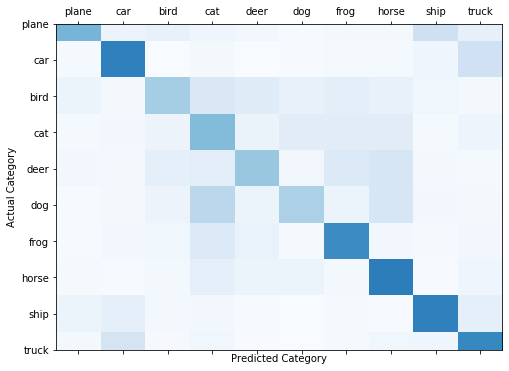

In [0]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

From the above visualisation we can see that the best accuracy was achieved on the **`car`** and **`ship`** categories, darkest shades present on the main diagonal. The **`truck`** category was most frequently confused with the **`car`** category. This is understandable, since they are both vehicles and have some visual similarities. **`Planes`** were also commonly confused with **`bird`** and **`ship`**. This could have something to do with a common background texture and colour, blue for both sky and sea. **`cat`** were also commonly confused with **`dog`** and **`frog`**.

To understand precisely which categories were most commonly confused, we can print the absolute and relative values of the confusion matrix, as follows.

In [0]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           469       56        72        40        31        6         16        23        205       82        
                0.469     0.056     0.072     0.04      0.031     0.006     0.016     0.023     0.205     0.082     
car             12        691       0         18        2         7         13        15        42        200       
                0.012     0.691     0.0       0.018     0.002     0.007     0.013     0.015     0.042     0.2       
bird            54        19        355       143       120       73        100       77        38        21        
                0.054     0.019     0.355     0.143     0.12      0.073     0.1       0.077     0.038     0.021     
cat             15        24        58        441       66        111       112       113       12        48        
                0.015     0.024     0.058     0.441     0.066   

# Conclusion
In this notebook, we trained a simple convolutional neural network using PyTorch on the CIFAR-10 data set. 50,000 images were used for training and 10,000 images were used to evaluate the performance. The model performed well, achieving an accuracy of 53.77% compared to a baseline of 10%, since there are 10 categories in CIFAR-10, if the model guessed randomly.

To improve the performance we can try adding convolution layers, more filters or more fully connected layers. We could also train the model for more than two epochs while introducing some form of regularisation, such as dropout or batch normalization, so as not to overfit the training data.

Keep in mind that complex models with hundreds of thousands of parameters are computationally more expensive to train and thus you should consider training such models on a GPU enabled machine to speed up the process.